In [1]:
# Import required libraries.
import numpy as np # for numerical computing
import math # for basic arithmatic computations
import pandas as pd # for manipulating CSV files and DataFrame
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import datetime # for datetime manipulations
import yfinance as yf # for data acquisition from Yahoo Finance
import seaborn as sn # for complex data visualization
import matplotlib as mpl # for simple data plotting
import matplotlib.pyplot as plt
from pprint import pprint # pretty print
from sklearn import linear_model # for linear regression
from numba import njit, prange # for parallel computing
import time # run time measure

NUM_TRADING_DAYS = 252 # macro definition: total trading days of a year

## Load and Process the High Correlation Stock Data

Load the CSV data for high correlation stocks created in the data collection procedure. Add an additional
column for basket prices, which is essentially the mean of previous column items in each row.

In [2]:
high_corr_stocks = ['CVX' , 'MPC', 'PSX', 'XOM']
high_corr_stocks_df = pd.read_csv('../Results/high_correlation_stocks.csv')
high_corr_stocks_df.columns = ['Date', 'CVX' , 'MPC', 'PSX', 'XOM']
high_corr_stocks_df.set_index('Date', inplace=True)
display(high_corr_stocks_df)

,CVX,MPC,PSX,XOM
Date,,,,
2018-12-31,101.839668,55.314468,81.296181,62.932121
2019-01-02,103.618286,55.905022,83.155182,64.316460
2019-01-03,101.633728,55.089500,82.003922,63.328960
2019-01-04,103.739975,57.789143,85.721931,65.663887
2019-01-07,105.087990,58.360939,86.316437,66.005356
...,...,...,...,...
2019-12-23,117.218971,59.060181,110.148331,67.977135
2019-12-24,117.228706,59.362007,110.666473,67.716011
2019-12-26,117.481995,58.875191,109.551987,67.822395


### Compute Percentage Returns

In [3]:
pct_returns_df = high_corr_stocks_df.pct_change(1).copy()
pct_returns_df['Basket'] = pct_returns_df.mean(numeric_only=True, axis=1)
W = np.array([0.25, 0.25, 0.25, 0.25]) # weight vector

for i in range (1, pct_returns_df.shape[0]):
    pct_returns_df.iloc[i]['Basket'] = np.dot(np.array(pct_returns_df.iloc[i].values[:4]), W)
# Compute for the last row.
display(pct_returns_df)

,CVX,MPC,PSX,XOM,Basket
Date,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN
2019-01-02,0.017465,0.010676,0.022867,0.021997,0.018251
2019-01-03,-0.019153,-0.014588,-0.013845,-0.015354,-0.015735
2019-01-04,0.020724,0.049005,0.045339,0.036870,0.037984
2019-01-07,0.012994,0.009895,0.006935,0.005200,0.008756
...,...,...,...,...,...
2019-12-23,0.005431,-0.015420,-0.005999,0.005004,-0.002746
2019-12-24,0.000083,0.005110,0.004704,-0.003841,0.001514
2019-12-26,0.002161,-0.008201,-0.010071,0.001571,-0.003635


### Compute volatility of the percentage returns for Basket Column

In [4]:
pct_returns_avg = pct_returns_df.mean()
basket_avg = pct_returns_avg['Basket'] * NUM_TRADING_DAYS
print(f'Average annualized percentage return of the Basket Option: {basket_avg * 100:.4f}%')

pct_returns_vol = pct_returns_df.std()
basket_vol = pct_returns_vol['Basket']
print(f'Volatility of the percentage returns of the Basket Option: {basket_vol}')

basket_sigma = basket_vol * np.sqrt(NUM_TRADING_DAYS)
print(f'Annualized volatility of the percentage returns of the Basket Option: {basket_sigma}')

Average annualized percentage return of the Basket Option: 16.1128%
Volatility of the percentage returns of the Basket Option: 0.011869354211124384
Annualized volatility of the percentage returns of the Basket Option: 0.18842015679343416


## Compute Correlations

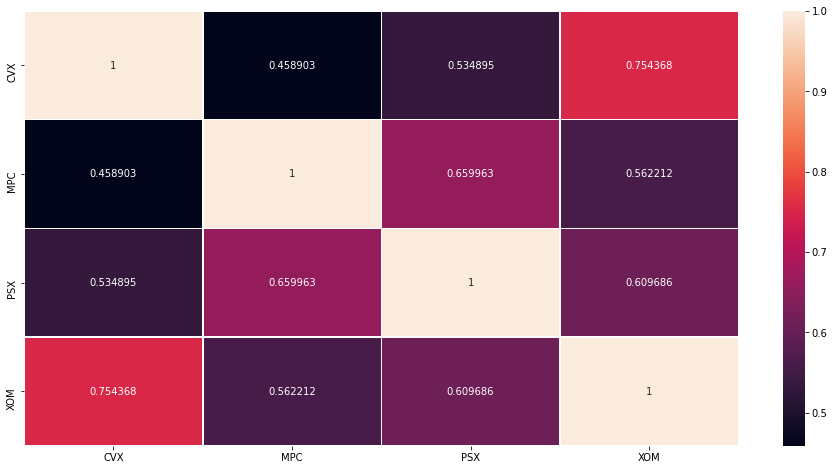

In [5]:
correlation_matrix = high_corr_stocks_df.pct_change(1).corr()
plt.figure(figsize = (16,8))
sn.heatmap(correlation_matrix, annot=True, fmt='g', linewidths=.5)
plt.show()

It can be easily seen that the selected stocks are highly correlated.

## Perform Cholesky Decomposition

References:
1. https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/
2. https://en.wikipedia.org/wiki/Cholesky_decomposition

Cholesky Decomposition comes handy when we need to generate correlated random numbers during Monte Carlo Simulation, the basic assumption of Cholesky Decomposition is that the (correlation) matrix is *Hermitian* and *Positive-Definite*, to compute Cholesky Decomposition of our correlation matrix, here we will use the **Cholesky-Banachiewicz Algorithm**. Specifically, for a Hermitian and Positive-Definite matrix **A**,

$$\mathbf{A} = \mathbf{L}\mathbf{U} = \mathbf{L}\mathbf{L^T} = \begin{bmatrix}&L_{11}, &0, &0\\&L_{21}, &L_{22}, &0\\&L_{31}, &L_{32}, &L_{33}\end{bmatrix}\begin{bmatrix}&L_{11}, &L_{21}, &L_{31}\\&0, &L_{22}, &L_{32}\\&0, &0, &L_{33}\end{bmatrix}$$

Then we have, by solving the LU-Decomposition of the matrix, the lower-triangular matrix $\mathbf{L}$ is,
$$\mathbf{L} = \begin{bmatrix}
&\sqrt{A_{11}}, &0,                              &0\\
&A_{21}/L_{11}, &\sqrt{A_{22} - L_{21}^2},       &0\\
&A_{31}/L_{11}, &(A_{32} - L_{31}L_{21})/L_{22}, &\sqrt{A_{33} - L_{31}^2 - L_{21}^2}
\end{bmatrix}$$

Hence, we have, for the diagonal elements of $\mathbf{L}$,
$$L_{j, j} = \pm \sqrt{A_{j,j} - \Sigma_{k=1}^{j-1}L_{j,k}^2}$$
Which is always positive if $\mathbf{A}$ is real and positive-definite, and the non-diagonal elements,
$$L_{i,j} = \frac{1}{L_{j,j}}\left(A_{i,j} - \Sigma_{k=1}^{j-1}L_{i,k}L_{j,k}\right), i > j$$

In [6]:
def cholesky_decomp(A):
    """
    Perform Cholesky Decomposition using
    Cholesky-Banachiewicz Algorithm
    
    Args:
        list: Two dimensional list constaing
        the target correlation matrix.
    
    Return:
        np.array(): a numpy array containing
        the resulting lower triangular matrix.
    
    """
    
    n = len(A)

    # Initialize a zero matrix for L.
    L = np.zeros(A.shape)

    # Perform the Cholesky decomposition
    for j in range(n):
        for i in range(j, n):
            symmetric_sum = sum(
                L[i][k] * L[j][k] for k in range(i))
            
            if (j == i): # Diagonal elements
                L[j][j] = np.sqrt(
                    A[j][j] - symmetric_sum)
            else:
                # Non-diagonal elements
                L[i][j] = (1.0 / L[j][j] * 
                    (A[i][j] - symmetric_sum))
    return L

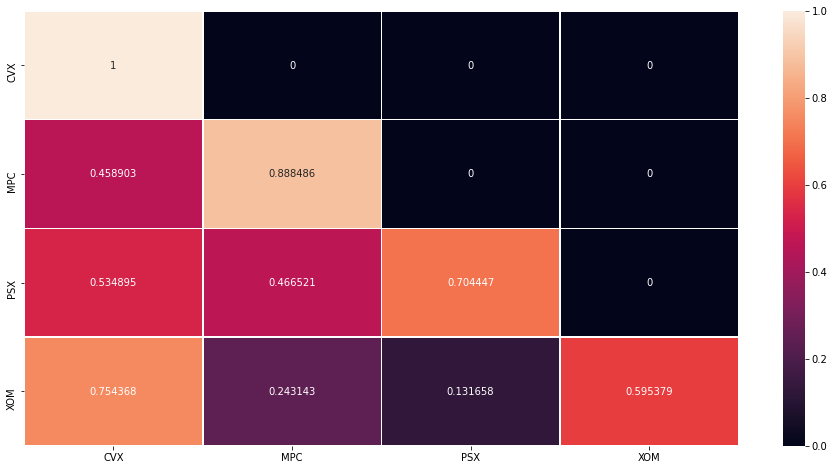

In [7]:
L = cholesky_decomp(correlation_matrix.values)
plt.figure(figsize = (16,8))
sn.heatmap(L, annot=True, fmt='g', linewidths=.5, xticklabels=high_corr_stocks, yticklabels=high_corr_stocks)
plt.show()

In [8]:
current_date = datetime.now().strftime('%Y-%m-%d')
print(current_date)
# Update with current date correspondingly.
spot_df = pd.DataFrame(yf.download('CVX MPC PSX XOM', start='2020-08-07', end='2020-08-08', progress=False)['Close'].iloc[-1])

2020-08-09


In [9]:
display(spot_df)

,2020-08-07
CVX,86.800003
MPC,36.669998
PSX,62.869999
XOM,43.439999


## Perform Monte-Carlo Simulation

### Simulation Parameters

In [10]:
spot = spot_df.mean().values[0]
print(f'The spot price of the basket options: {spot:.4f}')
strike = spot # in basket option, it is valid to assume that the strike price is equal to the spot price
print(f'The strike price of the basket options: {strike:.4f}')
alpha = 0.026
r = 0.026
T = 1
num_simulations = 10**7
spot_prices = np.array([spot_df.iloc[i].values[0] for i in range(len(high_corr_stocks))])
sigmas = high_corr_stocks_df.pct_change(1).std().values * np.sqrt(NUM_TRADING_DAYS)
print(sigmas)
num_stocks = len(high_corr_stocks)

The spot price of the basket options: 57.4450
The strike price of the basket options: 57.4450
[0.18439498 0.32249927 0.21149602 0.18380055]


### Generate correlated random numbers

In [11]:
uncor_random_nums = np.random.randn(num_simulations, len(high_corr_stocks))
cor_random_nums = np.dot(uncor_random_nums, L.T) # generate correlated random numbers using Cholesky Decomposition

In [12]:
st = np.zeros(num_simulations) # stock prices
ct = np.zeros(num_simulations) # call prices
pt = np.zeros(num_simulations) # put prices
st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices

@njit(parallel=True, fastmath=True)
def simulation(num_simulations, st, ct, pt, st_ind):
    for i in prange(num_simulations):

        # Compute current spot stock price.
        stock_prices = spot_prices * np.exp((0.026 - 0.5 * sigmas ** 2) * T + cor_random_nums[i] * sigmas * np.sqrt(T))
        st_ind[i,:] = stock_prices
        st_basket = np.dot(stock_prices, W)
        st[i] = st_basket

        # Compute call price.
        ct[i] = max(st_basket - strike, 0)

        # Compute put price.
        pt[i] = max(strike - st_basket, 0)

start_time = time.time()
simulation(num_simulations, st, ct, pt, st_ind)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.3330349922180176 seconds ---


Text(0.5, 1.0, 'Call Options for High Correlation Basket')

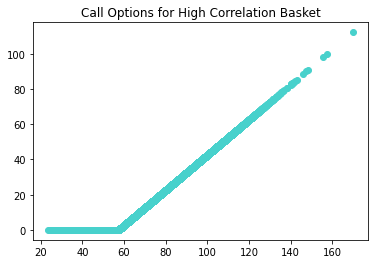

In [13]:
# Generate scatter plot for Call Options.
plt.scatter(st, ct, color='mediumturquoise')
plt.title('Call Options for High Correlation Basket')

Text(0.5, 1.0, 'Put Options for High Correlation Basket')

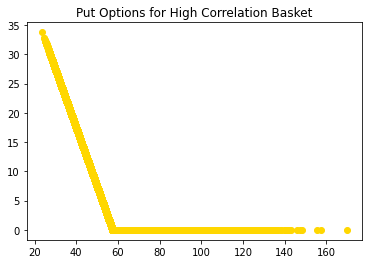

In [14]:
# Generate scatter plot for Put Options.
plt.scatter(st, pt, color='gold')
plt.title('Put Options for High Correlation Basket')

### Call Option Simulation Statistics

In [15]:
call_highcorr_avg = np.mean(ct)
print(f'Average call option pricing for high correlation stocks: {call_highcorr_avg:.4f}')
call_highcorr_C0 = call_highcorr_avg * np.exp(- r * T)
print(f'Call option C0 for high correlation stocks: {call_highcorr_C0:.4f}')

Average call option pricing for high correlation stocks: 4.9328
Call option C0 for high correlation stocks: 4.8062


## Perform Linear Regression on Call Option

In [16]:
# Create linear regression object.
lr_model = linear_model.LinearRegression()

x = np.array(st_ind)
y = np.array(ct)

# Training for call options.
lr_model.fit(x, y)

print('Model Parameters:')
print('Intercept:', lr_model.intercept_)
print('Slope:', lr_model.coef_)
C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
print(f'C0: {C0_linear_model:.4f}')

Model Parameters:
Intercept: -31.635333562411812
Slope: [0.15286469 0.18312307 0.15050937 0.14228213]
C0: 4.8036


### Generate Trendline

Text(0.5, 1.0, 'Call Options for High Correlation Basket')

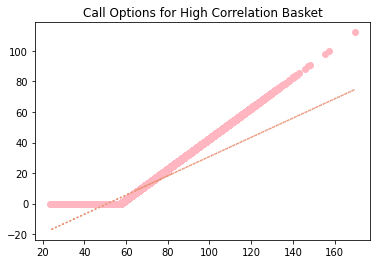

In [17]:
# Training for call options.
lr_model.fit(np.array(st).reshape((-1,1)), ct)

# Make fitting predictions.
call_pred = lr_model.predict(np.array(st).reshape((-1,1)))

plt.scatter(st, ct,  color='lightpink')
plt.plot(st, call_pred, linestyle=':', color='darksalmon')
plt.title('Call Options for High Correlation Basket')

## Put Option Statistics

In [18]:
put_highcorr_avg = np.mean(pt)
print(f'Average put option pricing for high correlation stocks: {put_highcorr_avg:.4f}')
put_highcorr_C0 = put_highcorr_avg * np.exp(- r * T)
print(f'Put option C0 for high correlation stocks: {put_highcorr_C0:.4f}')

Average put option pricing for high correlation stocks: 3.4155
Put option C0 for high correlation stocks: 3.3278


## Perform Linear Regression on Put Option

In [19]:
# Create linear regression object.
lr_model = linear_model.LinearRegression()

x = np.array(st_ind)
y = np.array(pt)

# Training for call options.
lr_model.fit(x, y)

print('Model Parameters:')
print('Intercept:', lr_model.intercept_)
print('Slope:', lr_model.coef_)
P0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
print(f'P0: {P0_linear_model:.4f}')

Model Parameters:
Intercept: 25.809666132411316
Slope: [-0.09713531 -0.06687693 -0.09949063 -0.10771787]
P0: 3.3293


### Generate Trendline

Text(0.5, 1.0, 'Put Options for High Correlation Basket')

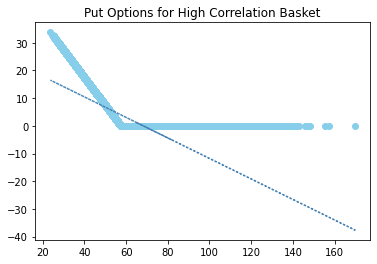

In [20]:
# Training for call options.
lr_model.fit(np.array(st).reshape((-1,1)), pt)

# Make fitting predictions.
put_pred = lr_model.predict(np.array(st).reshape((-1,1)))

plt.scatter(st, pt,  color='skyblue')
plt.plot(st, put_pred, linestyle=':', color='steelblue')
plt.title('Put Options for High Correlation Basket')

## Sensitivity Analysis

### Call VS Strike

In [21]:
call_strike = 40
num_simulations = 10**6

call_strikes = np.zeros(20)
C0_call_strike = np.zeros(20)

@njit(parallel=True, fastmath=True)
def simulation_strike(num_simulations, st, ct, pt, st_ind, strike):
        for i in prange(num_simulations):

            # Compute current spot stock price.
            stock_prices = spot_prices * np.exp((0.026 - 0.5 * sigmas ** 2) * T + cor_random_nums[i] * sigmas * np.sqrt(T))
            st_ind[i,:] = stock_prices
            st_basket = np.dot(stock_prices, W)
            st[i] = st_basket

            # Compute call price.
            ct[i] = max(st_basket - strike, 0)
            
            # Compute put price.
            pt[i] = max(strike - st_basket, 0)

for i in range(20):
    st = np.zeros(num_simulations) # stock prices
    ct = np.zeros(num_simulations) # call prices
    pt = np.zeros(num_simulations) # put prices
    st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices
    
    simulation_strike(num_simulations, st, ct, pt, st_ind, call_strike)
    
    # Create linear regression object.
    lr_model = linear_model.LinearRegression()

    x = np.array(st_ind)
    y = np.array(ct)

    # Training for call options.
    lr_model.fit(x, y)
    C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
    
    C0_call_strike[i] = C0_linear_model
    call_strikes[i] = call_strike
    
    call_strike += 2

Text(0.5, 1.0, 'Call VS Strike for High Correlation Basket')

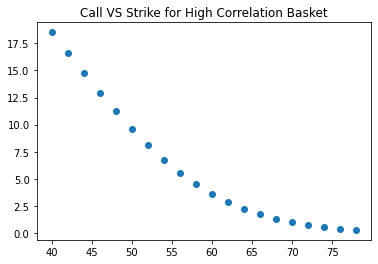

In [22]:
plt.scatter(call_strikes, C0_call_strike)
plt.title('Call VS Strike for High Correlation Basket')

In [23]:
call_vol = 0.0
num_simulations = 10**6

call_vols = np.zeros(20)
C0_call_vol = np.zeros(20)

@njit(parallel=True, fastmath=True)
def simulation_vol(num_simulations, st, ct, pt, st_ind, vol):
        for i in prange(num_simulations):

            # Compute current spot stock price.
            stock_prices = spot_prices * np.exp((0.026 - 0.5 * (sigmas + vol) ** 2) * T + cor_random_nums[i] * (sigmas + vol) * np.sqrt(T))
            st_ind[i,:] = stock_prices
            st_basket = np.dot(stock_prices, W)
            st[i] = st_basket

            # Compute call price.
            ct[i] = max(st_basket - strike, 0)
            
            # Compute put price.
            pt[i] = max(strike - st_basket, 0)
            
for i in range(20):
    st = np.zeros(num_simulations) # stock prices
    ct = np.zeros(num_simulations) # call prices
    pt = np.zeros(num_simulations) # put prices
    st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices
    
    simulation_vol(num_simulations, st, ct, pt, st_ind, call_vol)
    
    # Create linear regression object.
    lr_model = linear_model.LinearRegression()

    x = np.array(st_ind)
    y = np.array(ct)

    # Training for call options.
    lr_model.fit(x, y)
    C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
    
    C0_call_vol[i] = C0_linear_model
    call_vols[i] = call_vol
    
    call_vol += 0.02

Text(0.5, 1.0, 'Call VS Volatility for High Correlation Basket')

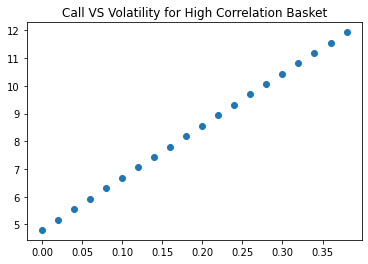

In [24]:
plt.scatter(call_vols, C0_call_vol)
plt.title('Call VS Volatility for High Correlation Basket')